In [1]:
# Xiaopu Peng

In [1]:
# check whats in the root folder
from subprocess import check_output
print(check_output(['ls', './']).decode('utf8'))

ExpCompareAll.ipynb
ExpCompareBasic.ipynb
ExpFixWorkload.ipynb
ExpUPScompare.ipynb
UPScompare.eps
__pycache__
compareAll.eps
compareAll.pdf
compareAll.png
comparision
fixWorkloadCompare.eps
fixWrokloadCompare.eps



# Imports

In [2]:
import sys
sys.path.insert(0, '/Users/xiaopupeng/Dropbox/WorkSpace/Redux/')
import random
import Methods as mt
import numpy as np
import pandas as pd
# %matplotlib inline
%matplotlib notebook
# %matplotlib widget
import matplotlib.pyplot as plt
# import Redux as rd
plt.style.use('ggplot')
# plt.style.use('default')

## Initialize

In [3]:
# ############CONSTANT############
# ratio of stats count when start the arithmetic average estimate
scaleRatio = 0.01
# ability of ups devise, could be more sophisticated in future (kWh)
upsCapability = 500
# the workload processing capability of data center (by kWh energy need)
workloadCapability = 2500
# ups and renewable energy price ($)
upsPrice = 0.02
solarPrice = 0.09
windPrice = 0.15

# ##############INITIALIZE###################
# initialized ups original storage by ratio
initUpsStorage = upsCapability * 0.5
# save the amount of deferred workload to a cache
initWorkloadPool = 0
# the initialized threshold of grid price ($)
initGridpriceThreshold = 1.0
# initialized high and low ratio of current workload for workload shaving
initCurWorkloadRatio = 0.2
# initialized stable renewable supply level
initStableRenSupply = 500
# initialize statistic recorders  and
gridpriceStat = []
workloadStat = []
renSupplyStat = []
fluRenSupplyStat = []  # renewable supply fluctuation
stableRenSupplyStat = []  # stable renewable supply

# initialize all statistical records
reduxStat = []
noReduxStat = []
costGapStat = []
specialCase = []
reduxAccu = []
noReduxAccu = []

reupsStat = []
reupsAccu = []
greenswitchStat = []
greenswitchAccu = []
#######################################

## Dataset

In [4]:
dataDir = '/Users/xiaopupeng/Dropbox/WorkSpace/Redux/data/'
workloadData, gridpriceData, solarSupplyData, windSupplyData, renSupplyData = mt.loadData(dataDir)

## Preprocess (need solar&wind model)

In [5]:
# gridmean = gridpriceData.mean()
# print(gridmean*1.1)

In [15]:
upsCapability = 1000

# topLevel

In [16]:
gridpriceThreshold = initGridpriceThreshold
workloadPool = initWorkloadPool
curWorkloadRatio = initCurWorkloadRatio
stableRenSupply = initStableRenSupply
upsStorage = initUpsStorage

curTime = 0
finTime = 2568  # number of timeslots
WINDOW = finTime * scaleRatio

while curTime < finTime:
    # print('current time:', curTime)

    # derive renewable price by weighted average from wind and solar price
    renPrice = (windSupplyData[curTime] * windPrice + solarSupplyData[curTime] * solarPrice) / (windSupplyData[curTime] + solarSupplyData[curTime])

    # get the current grid price, append to grid price statistic and decide whether it is high or low
    
    #############
    gridPrice = gridpriceData[curTime]
#     gridPrice = gridmean*1.1
    ##############
    
    gridpriceStat.append(gridPrice)
    ###############
    # call method to estimate grid price state
    gridpriceThreshold, gridpriceState = mt.estimateGridPriceState(gridpriceStat, gridpriceThreshold, finTime, gridPrice, scaleRatio)
#     gridpriceState = random.choice(['high', 'low'])
    ###############

    # get the current workload and append to workload statistic, use real trace data for the next step
    curWorkload = workloadData[curTime]

    # first, do workload shaving to avoid over-capability load
    curWorkload, workloadPool = mt.workloadShaving(curWorkload, workloadCapability, workloadPool)
    workloadStat.append(curWorkload)
    
    # get the current workload and append to workload statistic
    renSupply = renSupplyData[curTime]
    renSupplyStat.append(renSupply)
    
    # calculate greenswitchCost (noRedux, but with renewable energy)
#     greenswitchCost = mt.calculateGreenswitchCost(renSupply, curWorkload, workloadPool, gridPrice, renPrice)
#     greenswitchStat.append(greenswitchCost)
#     greenswitchAccu.append(sum(greenswitchStat))

    # then smoothing the current workload by exponential windowed avarage
    curWorkload, workloadPool = mt.workloadSmoothing(curWorkload, workloadPool, workloadStat, WINDOW)

    # update the high and low ratio of workload according to smoothed workload, will approach to 0.8 and 0.2 as when more workload recorded
    curWorkloadHighRatio, curWorkloadLowRatio = mt.updateWorkloadRatio(workloadStat, finTime, curWorkloadRatio, scaleRatio)

    workloadState = mt.updateWorkloadState(curWorkload, curWorkloadHighRatio, curWorkloadLowRatio, workloadCapability)

    # decide utilization level of ups for current time spot
    upsAbility = mt.updateUpsUtilityLevel(workloadState, upsCapability)

    ############################################
    # define renewable state
    # we need to figure out how to define fluctuate and tell why we still use grid as
    # much as possible when grid price is low(by always set a low price), otherwise we lost our motivation
    renState = mt.defineRenState(renSupply, renSupplyStat, renSupplyData, WINDOW)
    ##############################################

    # smoothing supply and demand if necessary
    if renState == 'fluctuate':
        # record the fluctuating renewable supply
        fluRenSupplyStat.append(renSupply)
        # update the stable renewable supply level by historical fluctuate renewable supply stat
        stableRenSupply = mt.getStableRenSupply(fluRenSupplyStat, WINDOW)
        # conduct renewable energy supply
        renSupply, upsStorage, stableGridSupply, upsSupplyFlu = mt.renSupplySmooth(gridpriceState, gridPrice, renSupply, renPrice, stableRenSupply, upsAbility, upsStorage)
#     else:
#         upsSupplyFlu = 0
#         stableGridSupply = 0

    # dynamically decide overpeak workload level
    workloadOVR = mt.updateOverpeak(gridpriceState, curWorkloadHighRatio, curWorkloadLowRatio, workloadCapability, workloadPool, renState, renSupply, stableRenSupply, gridPrice, renPrice)

    # status['workloadState'] == 'overPeak'
    curWorkload, workloadPool = mt.workloadShaving(curWorkload, workloadOVR, workloadPool)

    # decide whether discharge or recharge UPS
    upsSupply, upsStorage = mt.updateUpsSupply(gridpriceState, curWorkload, workloadOVR, renState, upsStorage, upsCapability, upsSupplyFlu)

    # waste renSupply if it is higher than curWorkload
    if renSupply + upsSupply > curWorkload:
        renSupply = curWorkload - upsSupply

    # find gridSupply by supply constrain
    gridSupply = curWorkload - renSupply - upsSupply + stableGridSupply

    # calculate redux cost
    reduxCost = gridPrice * gridSupply + renPrice * renSupply + upsPrice * abs(upsSupply)

    #####################
    reduxStat.append(reduxCost)
    reduxAccu.append(sum(reduxStat))
    
#     reupsStat.append(reduxCost)
#     reupsAccu.append(sum(reupsStat))
    #####################

    curTime += 1

print('Finished')

Finished


In [8]:
print(reduxAccu)

[787.3612635756712, 1797.2676756268006, 2514.2769100233654, 2773.7346352631157, 3410.5847150660793, 3737.963200655055, 3747.9112156414094, 4221.433549798099, 4348.000305623487, 5040.330706155362, 5876.226364987049, 6511.638450600592, 7246.518401104416, 8403.053630206561, 9606.185030197032, 10920.400728052544, 11810.996580946674, 12086.1276169853, 14042.119794199494, 14756.300409739424, 15965.533537113262, 16550.887634017727, 16964.08297567081, 17576.585510944515, 18356.476428080005, 18891.86396785971, 19398.925561519096, 19896.909542505404, 20406.53711719054, 20895.73240958876, 21484.15978840088, 22513.239577095683, 23189.747980999084, 23762.35714901633, 24342.195966405885, 24872.622774963762, 25732.889288082843, 26548.420619898425, 27461.389998173232, 28388.955615745257, 29282.298261121992, 30124.699961181555, 30916.959002963944, 31781.313943117453, 32356.26066346109, 33306.19963825239, 33980.52424232816, 34773.24875506248, 35296.885658021354, 35713.581367991355, 36239.8059770991, 366

In [9]:
reduxStatUPS200 = reduxStat
reduxAccuUPS200 = reduxAccu
reduxStat = []
reduxAccu = []

In [13]:
reduxStatUPS500 = reduxStat
reduxAccuUPS500 = reduxAccu
reduxStat = []
reduxAccu = []

In [17]:
reduxStatUPS800 = reduxStat
reduxAccuUPS800 = reduxAccu
reduxStat = []
reduxAccu = []

In [18]:
len(reduxStatUPS500)

2568

In [19]:
%whos

Variable                 Type        Data/Info
----------------------------------------------
WINDOW                   float       25.68
check_output             function    <function check_output at 0x10bdadb00>
costGapStat              list        n=0
curTime                  int         2568
curWorkload              float64     1431.322268461953
curWorkloadHighRatio     float64     0.6849985867303006
curWorkloadLowRatio      float64     0.3445881992489125
curWorkloadRatio         float       0.2
dataDir                  str         /Users/xiaopupeng/Dropbox/WorkSpace/Redux/data/
finTime                  int         2568
fluRenSupplyStat         list        n=3631
greenswitchAccu          list        n=0
greenswitchStat          list        n=0
gridPrice                float64     0.4789
gridSupply               float64     1110.322268461953
gridpriceData            ndarray     2568: 2568 elems, type `float64`, 20544 bytes
gridpriceStat            list        n=7704
gridpriceState   

<IPython.core.display.Javascript object>


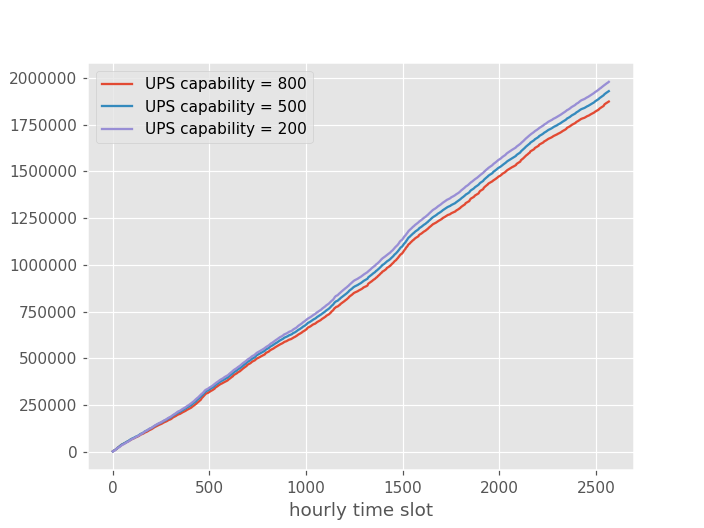

In [20]:
plt.plot(reduxAccuUPS800, label='UPS capability = 800')
plt.plot(reduxAccuUPS500, label='UPS capability = 500')
plt.plot(reduxAccuUPS200, label='UPS capability = 200')
plt.xlabel('hourly time slot')
plt.ylabel('dollars')
# plt.title('Accumulative total cost of Redux with UPS capability of 200, 500 and 800')
plt.legend(loc='best')
plt.show()

In [21]:
plt.savefig('UPScompare.png')
plt.close()

In [44]:
reduxAccuUPS800[-1]

2214511.3010417838

In [43]:
reduxAccuUPS500[-1]

2284645.9226746177

In [42]:
reduxAccuUPS200[-1]

2347214.6516659725

In [ ]:
# How to plot 3 graphs together
# for i, col, in enumerate(features.columns):
#     plt.subplot(1, 3, i+1)
#     x = data[col]
#     y = prices
#     plt.plot(x,y,'o')
#     plt.plot(np.unique(x), npplot1d(np.plotfit(x,y,1))(np.unique(x)))
#     plt.title(col)
#     plt.xlabel(col)
#     plt.ylable('prices')